In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from time import time

import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [57]:
stock_df = pd.read_json('../data/raw/StockSeries.json', orient='records')

In [58]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

(365, 1, 30) (365,)
(127, 1, 30) (127,)
4/4 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 4.731516727906753
Train Root Mean Squared Error: 5.770004298787776
Test Mean Absolute Error: 5.129965842618752
Test Root Mean Squared Error: 7.476514913037609
Train MAPE: 1.6854222656397915, Test MAPE: 1.7478699612587776
(365, 1, 30) (365,)
(127, 1, 30) (127,)
4/4 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 72.72641500101507
Train Root Mean Squared Error: 157.5504022039113
Test Mean Absolute Error: 15.738783067414857
Test Root Mean Squared Error: 16.047908023019037
Train MAPE: 16.977306377270978, Test MAPE: 11.476597006620933
(365, 1, 30) (365,)
(127, 1, 30) (127,)
4/4 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.8756296669172008
Train Root Mean Squared Error: 1.0956548960945212
Test Mean Absolute Error: 0.6637587820671583
Test Root Mean Squared Error: 0.8871163446383157
Train MAPE: 2.3142711599889796, Test MA

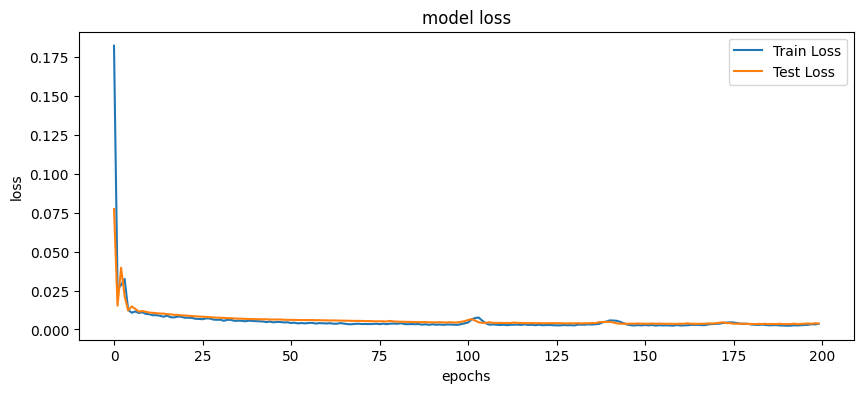

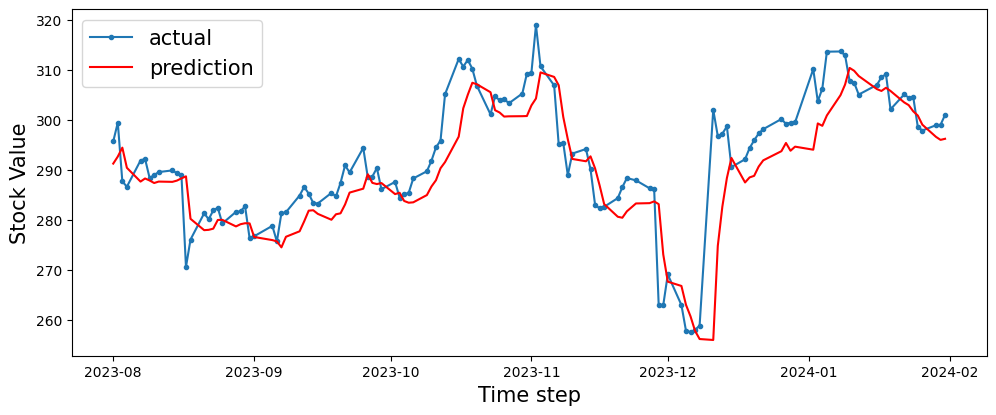

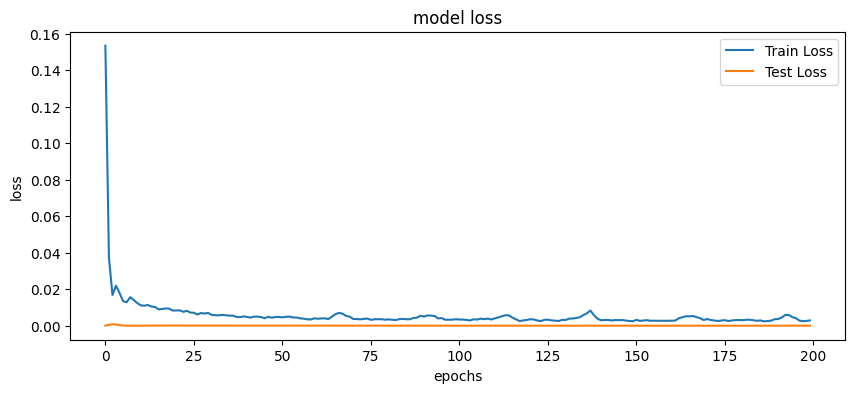

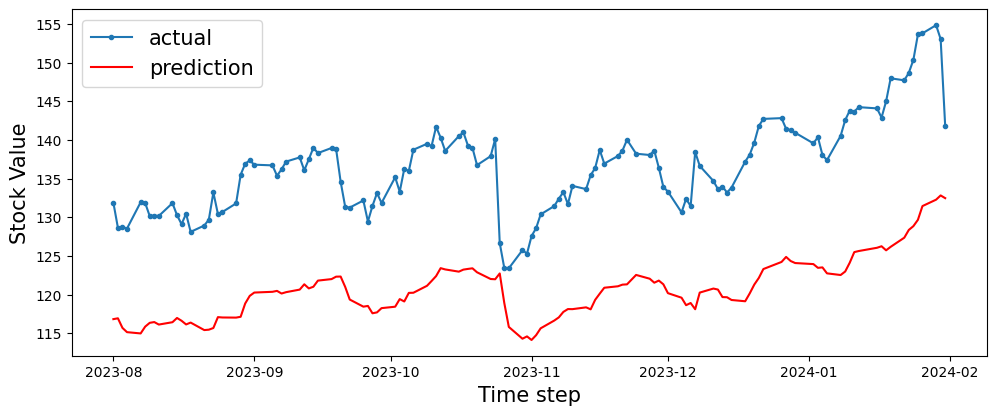

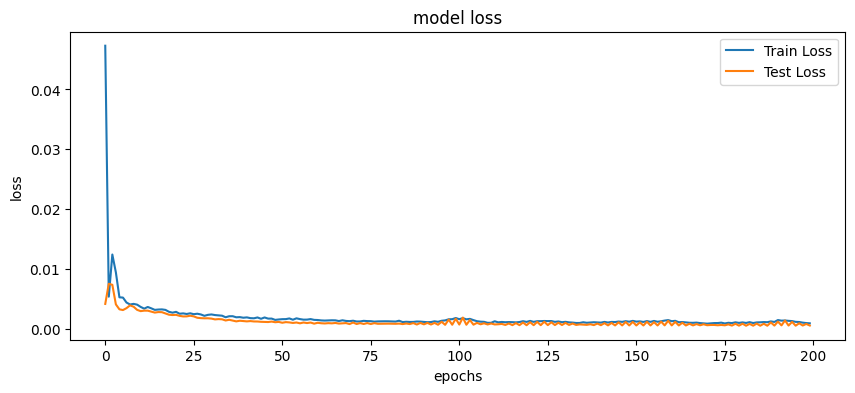

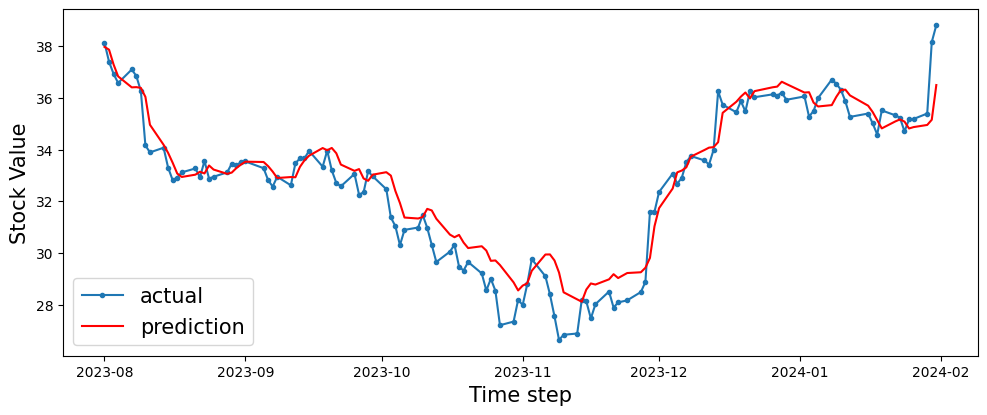

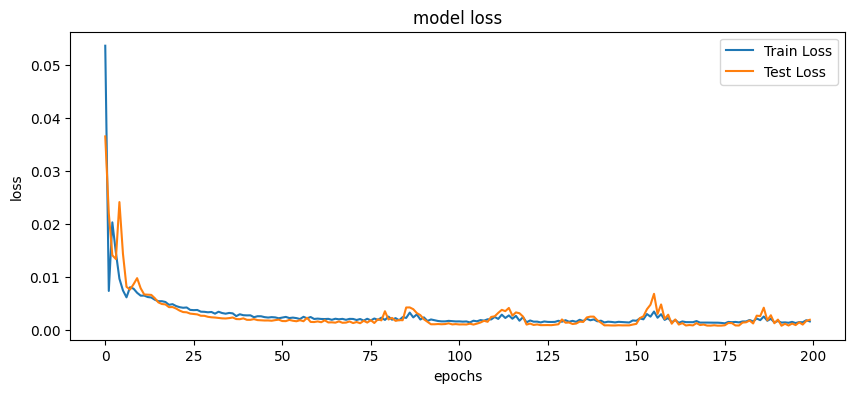

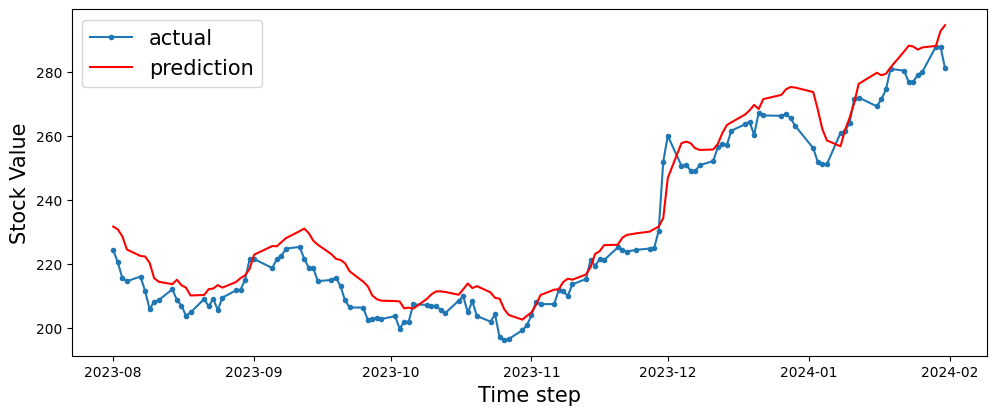

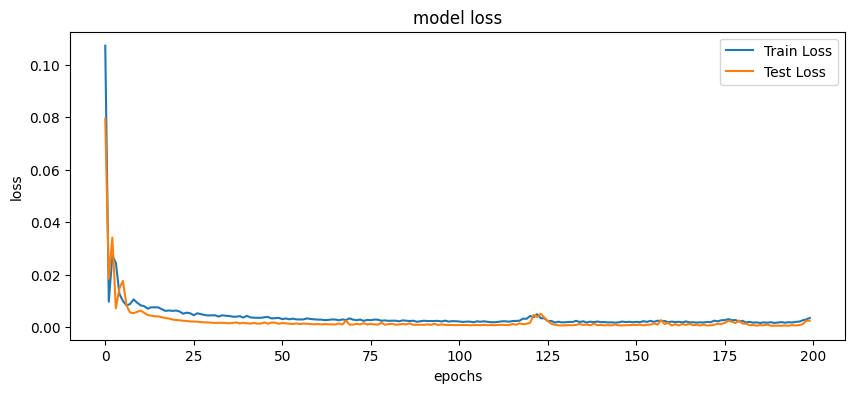

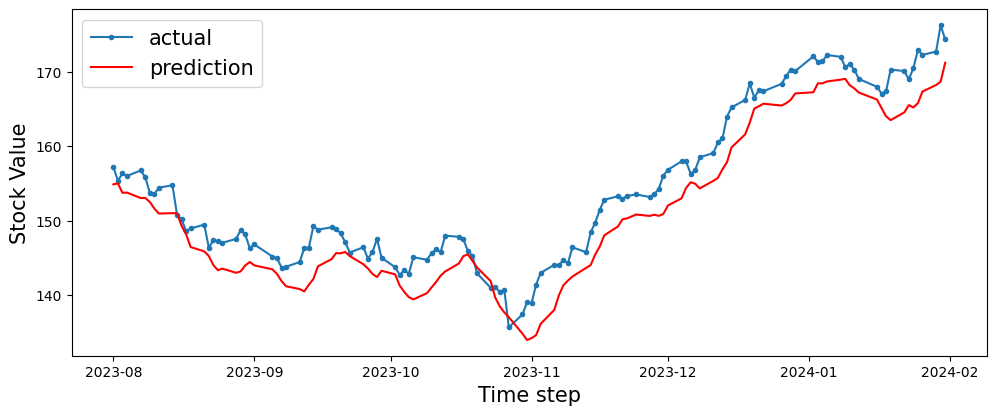

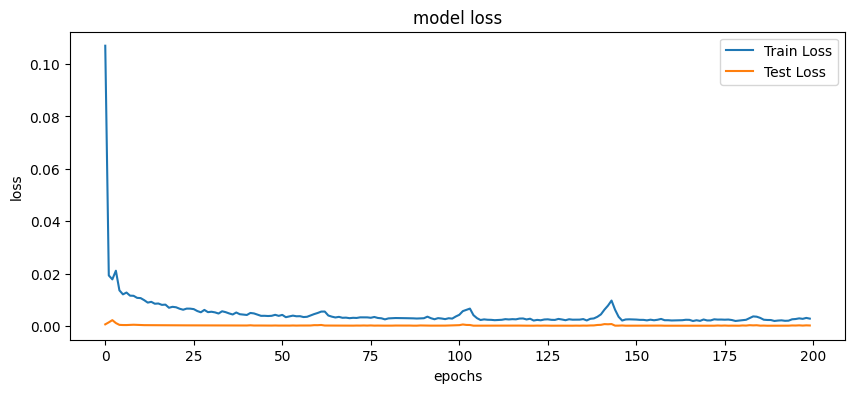

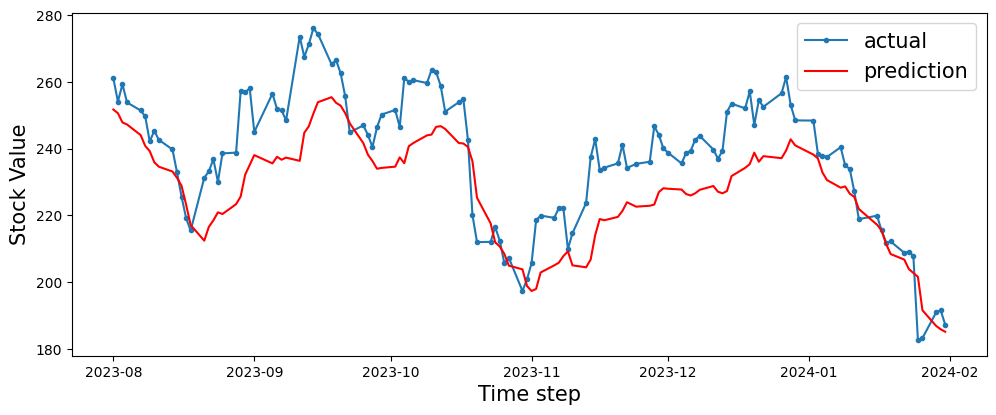

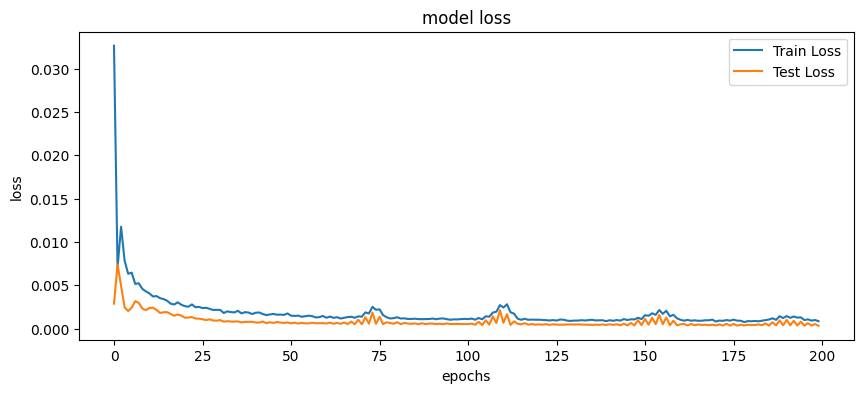

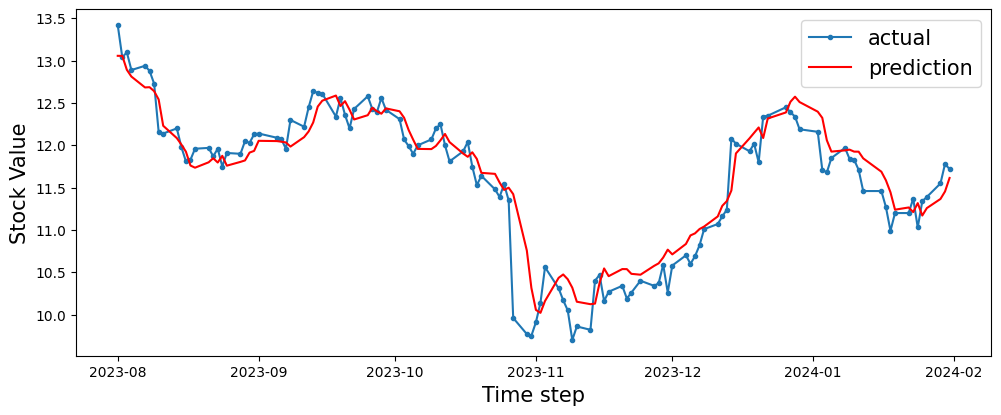

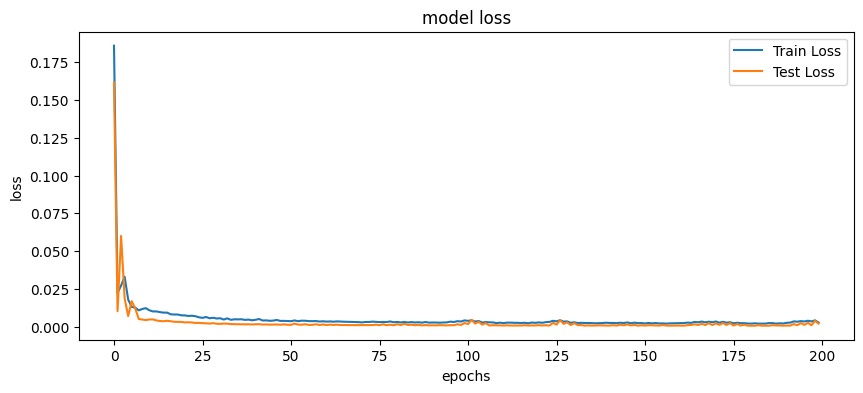

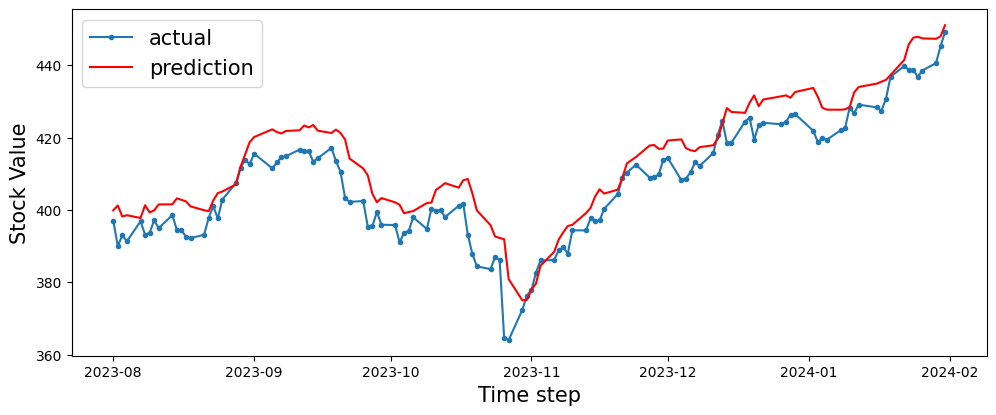

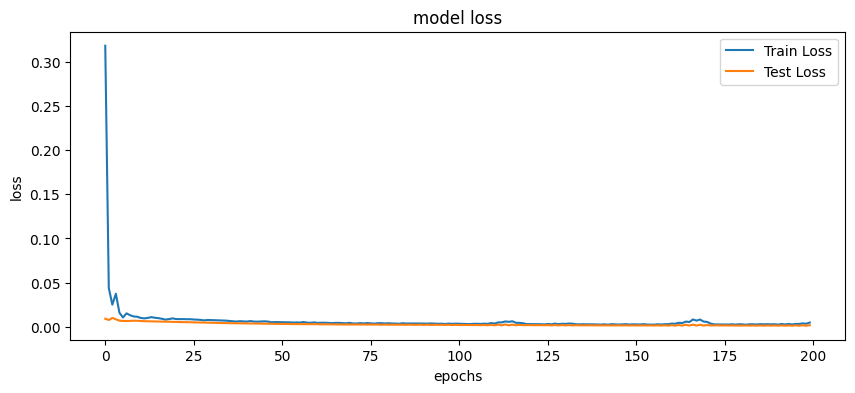

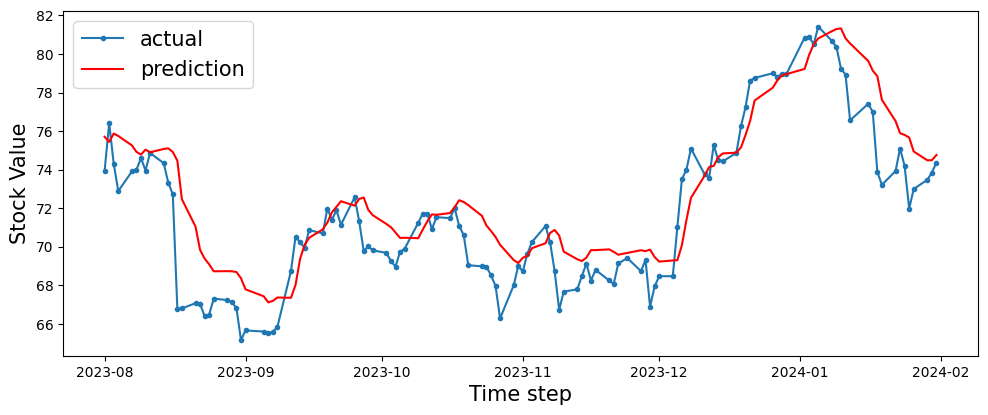

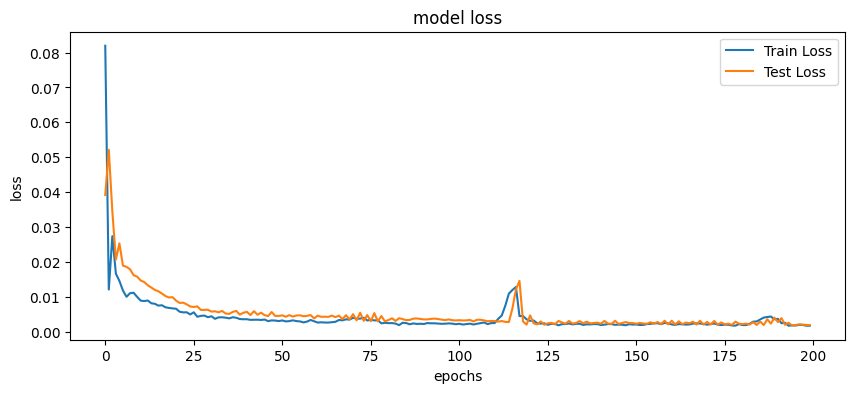

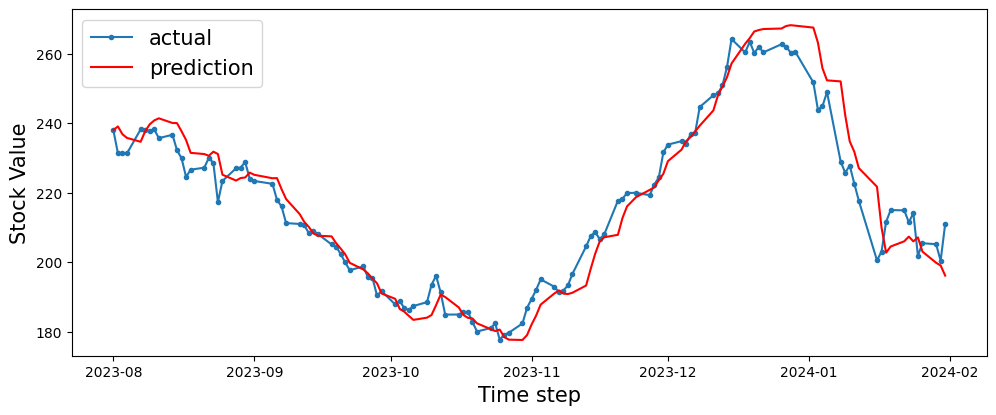

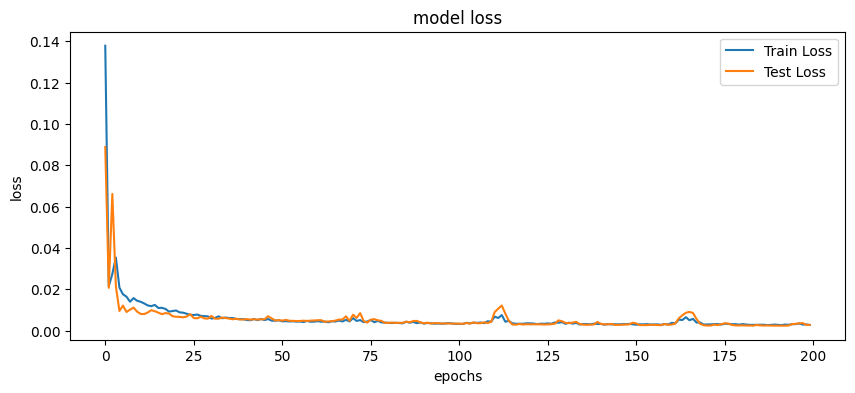

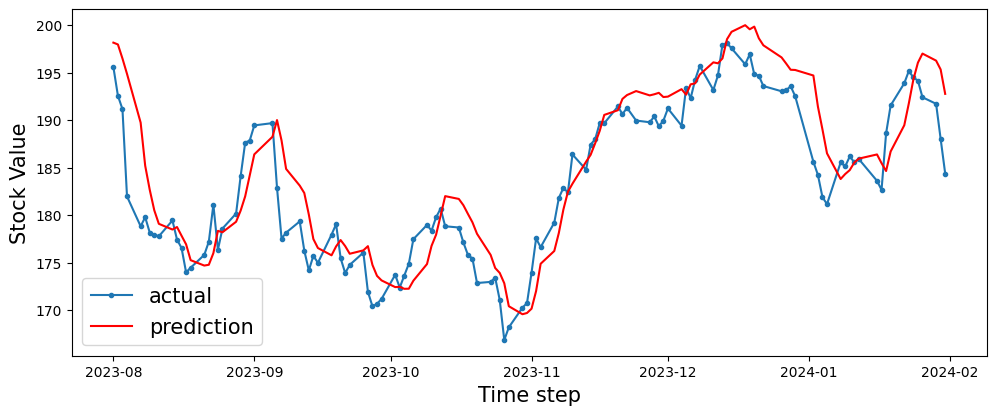

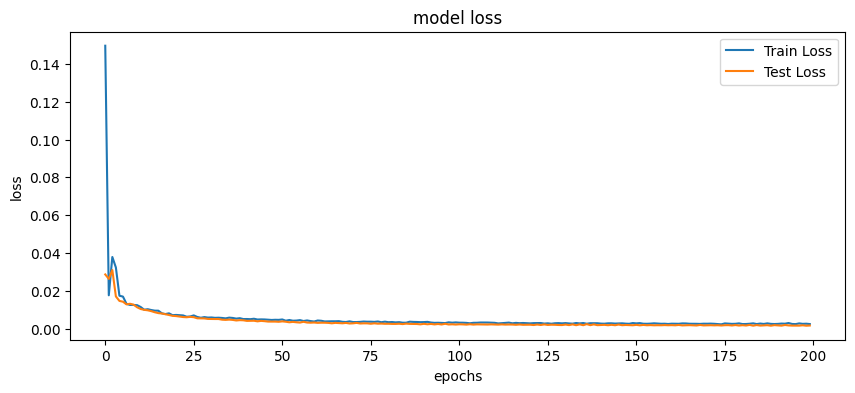

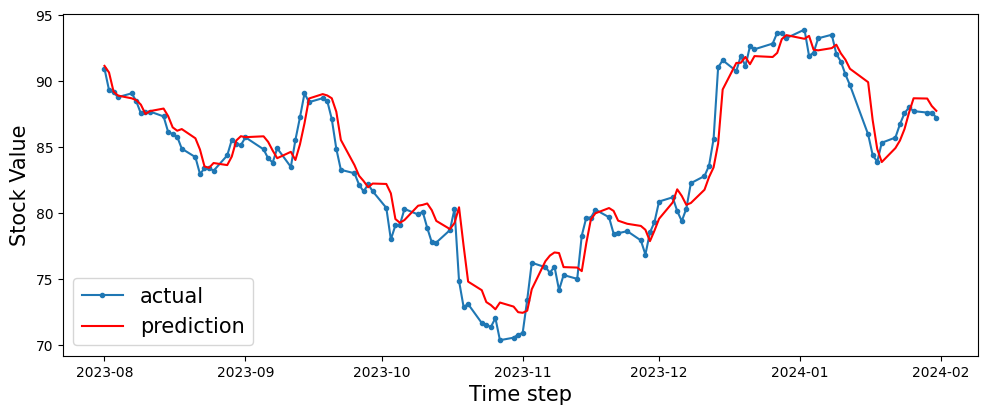

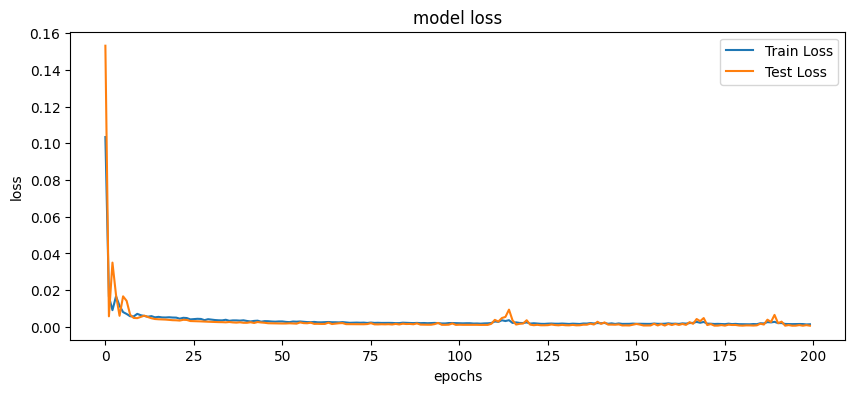

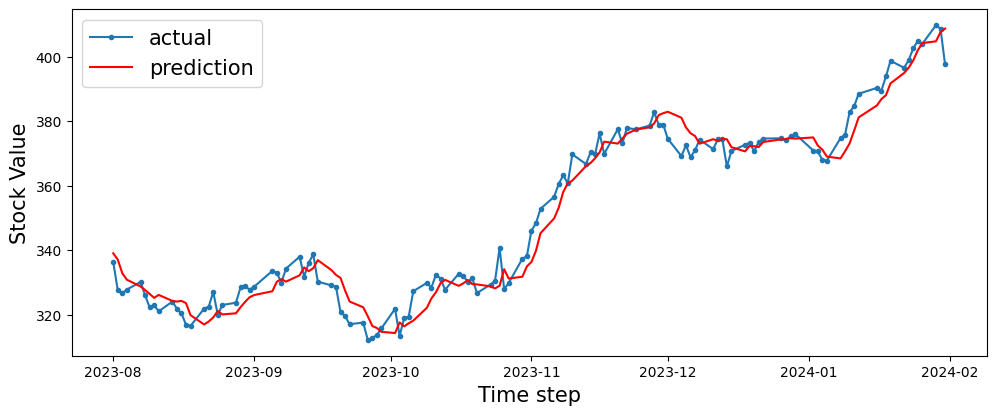

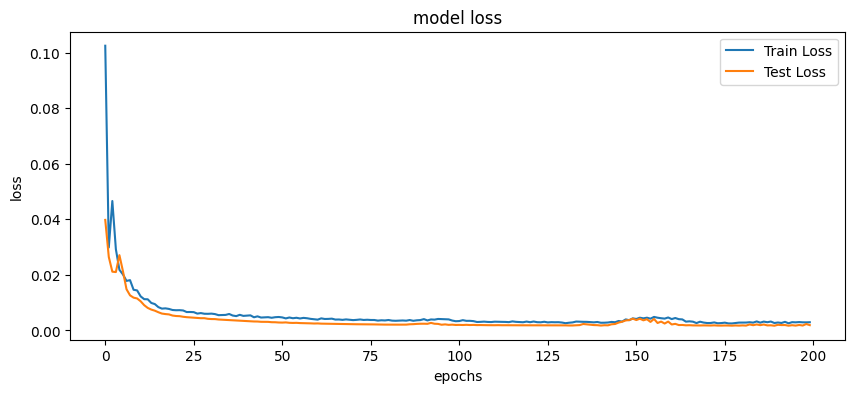

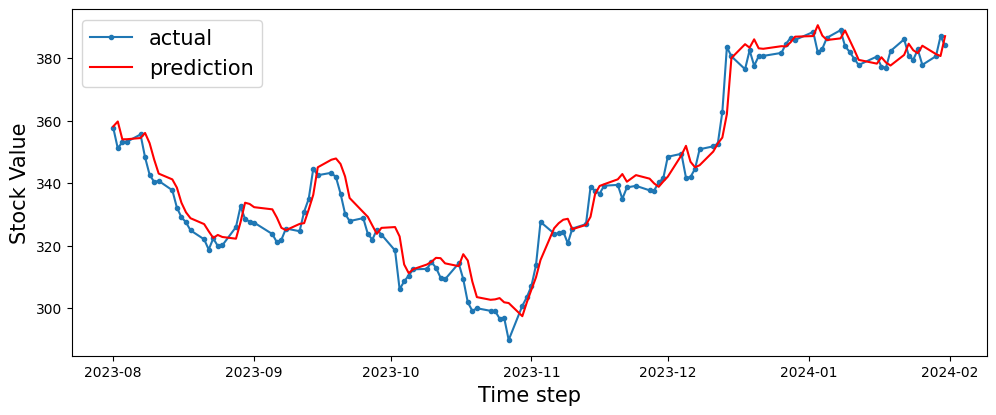

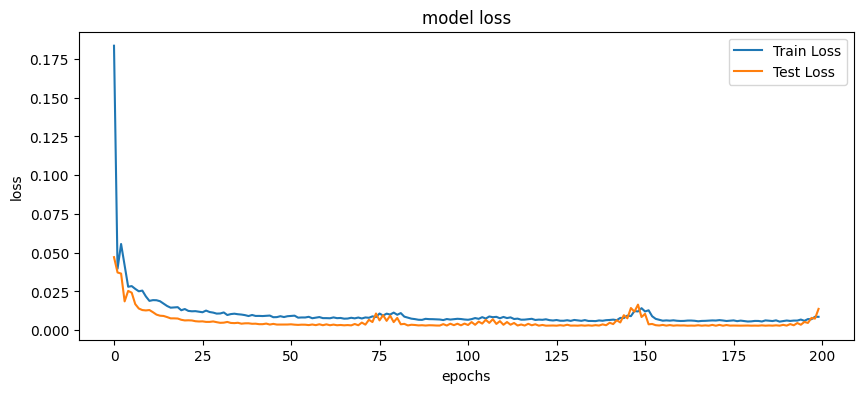

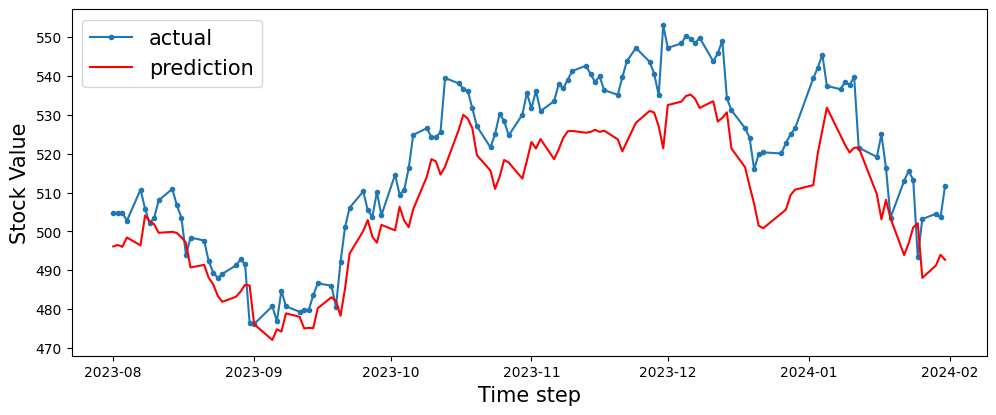

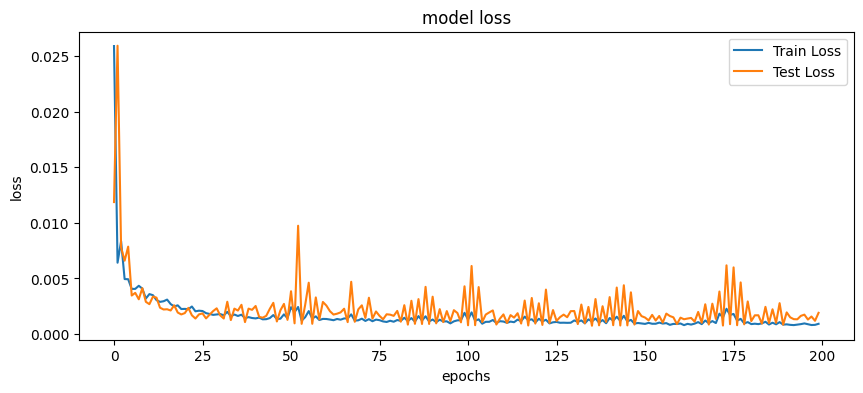

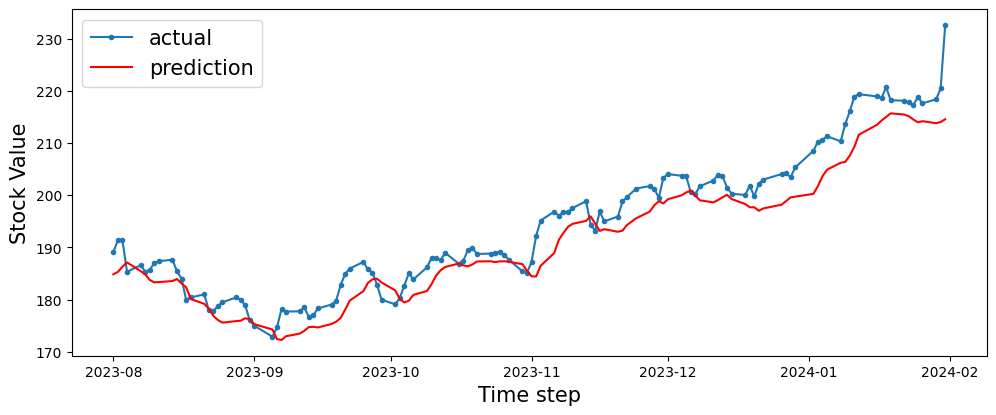

In [59]:
cids = stock_df['CID'].unique()
metrics = {
    'CID': [],
    'train_mae': [],
    'test_mae': [],
    'train_mase': [],
    'test_mase': [],
    'train_mape': [],
    'test_mape': []
}

for cid in cids:
    df = stock_df[stock_df['CID'] == cid].sort_values(by='Date')
    dataset = df['Close'].dropna().values #numpy.ndarray
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    joblib.dump(scaler, f'../models/Scalers/{cid}.pkl')     

    train_size = 395
    test_size = 127
    look_back = 30
    train, test = dataset[:train_size, :], dataset[train_size - look_back:len(dataset), :]
        

    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)

    # Train Model
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test), verbose=0, shuffle=False)
    model.save(f'../models/LSTM/{cid}.h5')

    # Evaluate
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])

    train_mae = mean_absolute_error(Y_train[0], train_predict[:,0])
    train_mase = mean_squared_error(Y_train[0], train_predict[:,0], squared=False)
    test_mae = mean_absolute_error(Y_test[0], test_predict[:,0])
    test_mase = mean_squared_error(Y_test[0], test_predict[:,0], squared=False)
    print('Train Mean Absolute Error:', train_mae)
    print('Train Root Mean Squared Error:', train_mase)
    print('Test Mean Absolute Error:', test_mae)
    print('Test Root Mean Squared Error:', test_mase)

    mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
    mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100
    print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

    metrics['CID'].append(cid)
    metrics['train_mae'].append(train_mae)
    metrics['train_mase'].append(train_mase)
    metrics['train_mape'].append(mape_train)
    metrics['test_mae'].append(test_mae)
    metrics['test_mase'].append(test_mase)
    metrics['test_mape'].append(mape_test)

    # Save Figures
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(f'../outputs/plots/{cid}_model_loss.png',  bbox_inches = 'tight')

    dates = df['Date'].iloc[-test_size:]
    plt.figure(figsize=(10, 4))
    plt.plot(dates, Y_test[0][:test_size], marker='.', label="actual")
    plt.plot(dates, test_predict[:,0][:test_size], 'r', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Stock Value', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.savefig(f'../outputs/plots/{cid}_test_predictions.png',  bbox_inches = 'tight')

    # Save LSTM predictions
    lstm_predictions = [-1] * 30
    lstm_predictions.extend([x[0] for x in train_predict])
    lstm_predictions.extend([x[0] for x in test_predict])

    df['lstm_predictions'] = lstm_predictions
    df[['CID', 'Date', 'lstm_predictions']].to_csv(f'../outputs/lstm_predictions/{cid}_predictions.csv', index=False)

pd.DataFrame(data=metrics).to_csv('../outputs/metrics/result.csv', index=False)